In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import os,sys,inspect

current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parent_dir = os.path.dirname(current_dir)
sys.path.insert(0, parent_dir)
import edhec_risk_kit as erk

import ipywidgets as widgets
from IPython.display import display

In [2]:
n_scenarios = 5000
rates, zc_prices = erk.cir(10, n_scenarios=n_scenarios, b=.03, r_0=.03, sigma=.02)
price_eq = erk.gbm(n_years=10, n_scenarios=n_scenarios, mu=.07, sigma=.15)

In [5]:
rets_eq = price_eq.pct_change().dropna()
rets_zc = zc_prices.pct_change().dropna()
rets_7030b = erk.bt_mix(rets_eq, rets_zc, allocator=erk.fixedmix_allocator, w1=.7)
pd.concat([
    erk.terminal_stats(rets_zc, name="FI", floor=.75),
    erk.terminal_stats(rets_eq, name="EQ", floor=.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=.75)
], axis=1).round(2)

,FI,EQ,70/30
mean,1.34,1.96,1.75
std,0.00,0.97,0.59
p_breach,NaN,0.04,0.01
e_short,NaN,0.12,0.07
p_reach,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN


In [6]:
rets_floor75 = erk.bt_mix(
    rets_eq, rets_zc, allocator=erk.floor_allocator, 
    floor=.75, zc_prices=zc_prices[1:]
)
pd.concat([
    erk.terminal_stats(rets_zc, name="FI", floor=.75),
    erk.terminal_stats(rets_eq, name="EQ", floor=.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=.75),
    erk.terminal_stats(rets_floor75, name="Floor75", floor=.75),
], axis=1).round(2)

,FI,EQ,70/30,Floor75
mean,1.34,1.96,1.75,1.94
std,0.00,0.97,0.59,0.98
p_breach,NaN,0.04,0.01,NaN
e_short,NaN,0.12,0.07,NaN
p_reach,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN


In [8]:
rets_floor75m1 = erk.bt_mix(
    rets_eq, rets_zc, allocator=erk.floor_allocator, 
    floor=.75, zc_prices=zc_prices[1:],
    m=1
)
rets_floor75m5 = erk.bt_mix(
    rets_eq, rets_zc, allocator=erk.floor_allocator, 
    floor=.75, zc_prices=zc_prices[1:],
    m=5
)
pd.concat([
    erk.terminal_stats(rets_zc, name="FI", floor=.75),
    erk.terminal_stats(rets_eq, name="EQ", floor=.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=.75),
    erk.terminal_stats(rets_floor75, name="Floor75", floor=.75),
    erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=.75),
    erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=.75),
], axis=1).round(4)

,FI,EQ,70/30,Floor75,Floor75m1,Floor75m5
mean,1.3433,1.9603,1.7510,1.9389,1.6177,1.9476
std,0.0000,0.9749,0.5936,0.9796,0.4304,0.9823
p_breach,NaN,0.0382,0.0084,NaN,NaN,0.0002
e_short,NaN,0.1225,0.0730,NaN,NaN,0.0004
p_reach,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN


## Risk budgeting with Drawdown Contraints

In [11]:
cashrate = .02
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data=monthly_cashreturn, index=rets_eq.index, columns=rets_eq.columns)
rets_maxdd25 = erk.bt_mix(
    rets_eq, rets_cash, allocator=erk.drawdown_allocator, 
    maxdd=.25
)
tv_maxdd25 = erk.terminal_values(rets_maxdd25)
pd.concat([
    erk.terminal_stats(rets_zc, name="FI", floor=.75),
    erk.terminal_stats(rets_eq, name="EQ", floor=.75),
    erk.terminal_stats(rets_7030b, name="70/30", floor=.75),
    erk.terminal_stats(rets_floor75, name="Floor75", floor=.75),
    erk.terminal_stats(rets_floor75m1, name="Floor75m1", floor=.75),
    erk.terminal_stats(rets_floor75m5, name="Floor75m5", floor=.75),
    erk.terminal_stats(rets_maxdd25, name="MaxDD25", floor=.75),
], axis=1).round(4)

,FI,EQ,70/30,Floor75,Floor75m1,Floor75m5,MaxDD25
mean,1.3433,1.9603,1.7510,1.9389,1.6177,1.9476,1.6229
std,0.0000,0.9749,0.5936,0.9796,0.4304,0.9823,0.5363
p_breach,NaN,0.0382,0.0084,NaN,NaN,0.0002,NaN
e_short,NaN,0.1225,0.0730,NaN,NaN,0.0004,NaN
p_reach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
e_surplus,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"]

0      -0.156788
1      -0.142567
2      -0.105896
3      -0.193711
4      -0.163774
          ...   
4995   -0.140083
4996   -0.151881
4997   -0.120489
4998   -0.181040
4999   -0.190767
Name: Max Drawdown, Length: 5000, dtype: float64

In [14]:
erk.summary_stats(rets_maxdd25)["Max Drawdown"].min()

-0.2320734919532883

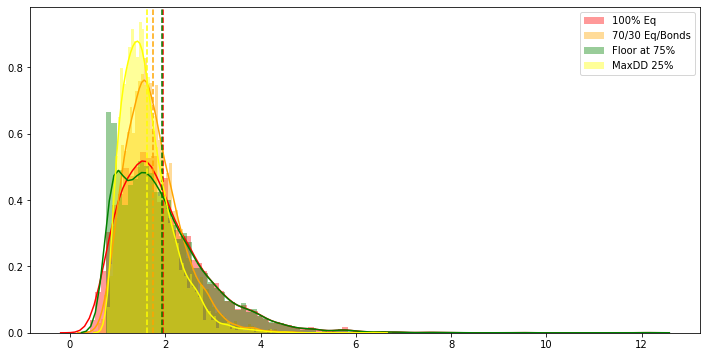

In [23]:
tv_eq = erk.terminal_values(rets_eq)
tv_zc = erk.terminal_values(rets_zc)
tv_7030b = erk.terminal_values(rets_7030b)
tv_floor75 = erk.terminal_values(rets_floor75)
tv_floor75m1 = erk.terminal_values(rets_floor75m1)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.distplot(tv_eq, color="red", label="100% Eq", bins=100)
plt.axvline(tv_eq.mean(), ls="--", color="red")

sns.distplot(tv_7030b, color="orange", label="70/30 Eq/Bonds", bins=100)
plt.axvline(tv_7030b.mean(), ls="--", color="orange")

sns.distplot(tv_floor75, color="green", label="Floor at 75%", bins=100)
plt.axvline(tv_floor75.mean(), ls="--", color="green")

sns.distplot(tv_maxdd25, color="yellow", label="MaxDD 25%", bins=100)
plt.axvline(tv_maxdd25.mean(), ls="--", color="yellow")

plt.legend()

## Drawdown constraint with Historical Data

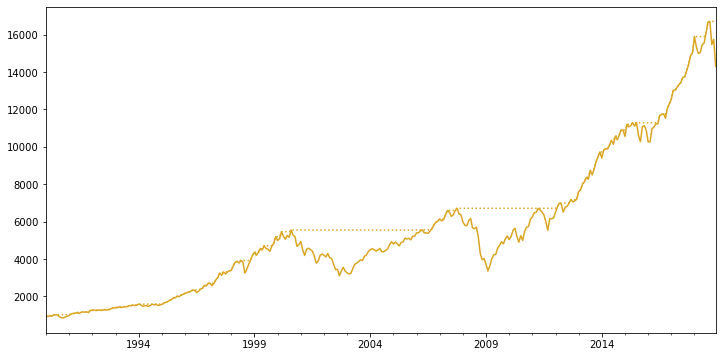

In [19]:
rets_tmi =  erk.get_total_market_index_returns()["1990":]
dd_tmi = erk.drawdown(rets_tmi)
ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod")
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")

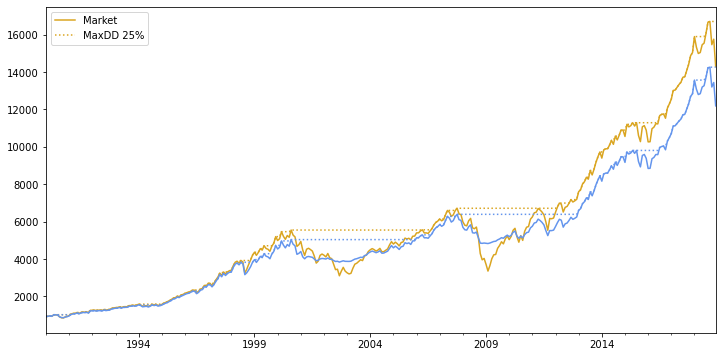

In [20]:
cashrate = 0.03
monthly_cashreturn = (1+cashrate)**(1/12) - 1
rets_cash = pd.DataFrame(data= monthly_cashreturn, index=rets_tmi.index, columns=[0]) # 1 column dataframe
rets_maxdd25 = erk.bt_mix(pd.DataFrame(rets_tmi), rets_cash, allocator=erk.drawdown_allocator, maxdd=.25, m=5)
dd_25 = erk.drawdown(rets_maxdd25[0])

ax = dd_tmi["Wealth"].plot(figsize=(12,6), ls="-", color="goldenrod", label="Market", legend=True)
dd_tmi["Previous Peak"].plot(ax=ax, ls=":", color="goldenrod")
dd_25["Wealth"].plot(ax=ax, label="MaxDD 25%", color="cornflowerblue", legend=True)
dd_25["Previous Peak"].plot(ax=ax, color="cornflowerblue", ls=":")

In [21]:
erk.summary_stats(pd.concat([rets_tmi.rename("Market"), rets_maxdd25[0].rename("MaxDD")], axis=1))

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Cornish-Fisher VaR (5%),Historic CVaR (5%),Sharpe Ratio,Max Drawdown
Market,0.096058,0.145419,-0.668827,4.247282,0.066949,0.094633,0.441951,-0.499943
MaxDD,0.090062,0.112755,-0.630463,5.015334,0.049978,0.071074,0.518327,-0.244212
